In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from dataclasses import dataclass
import yaml
import cv2
import math
import torch

In [29]:
PROTOTYPE_PATH = "prototypes/"
HNE_PATH = "/home/ct678/code/charm_data/aligned_hne"
MASK_PATH = "/home/ct678/aligned_masks"

In [30]:
prototype_paths = list(sorted(os.path.join(PROTOTYPE_PATH, filename) for filename in os.listdir(PROTOTYPE_PATH) if filename.endswith('.npz')))
num_prototypes = len(prototype_paths)
print(f"Found {num_prototypes} prototype files.")

Found 30 prototype files.


In [31]:
prototypes = []
for prototype_path in tqdm(prototype_paths, desc="Loading prototypes"):
    data = np.load(prototype_path, mmap_mode='r')['region']
    prototypes.append(data)
prototypes = np.stack(prototypes)
prototypes.shape

Loading prototypes:   0%|          | 0/30 [00:00<?, ?it/s]

Loading prototypes: 100%|██████████| 30/30 [01:06<00:00,  2.22s/it]


(30, 512, 512, 24)

In [32]:
# trivial prototypes if mostly zeros
trivial_prototypes = sum(1 for p in prototypes if np.count_nonzero(p) < 0.01 * p.size)
print(f"Number of trivial prototypes (mostly zeros): {trivial_prototypes}")

Number of trivial prototypes (mostly zeros): 3


In [33]:
flattened_prototypes = prototypes[:, :, :, 21].reshape(num_prototypes, -1)
flattened_prototypes.shape

(30, 262144)

100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


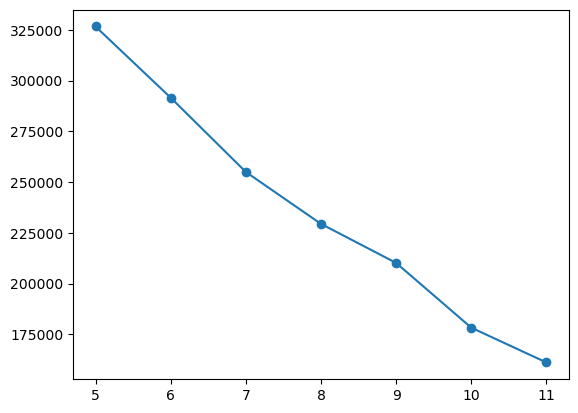

In [34]:
from sklearn.cluster import KMeans

inertia_values = []
possible_k_values = list(range(5, 12))
for k_val in tqdm(possible_k_values):
    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
    kmeans.fit(flattened_prototypes)
    inertia_values.append(kmeans.inertia_)
plt.plot(possible_k_values, inertia_values, marker='o')
plt.show()

In [49]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(flattened_prototypes)
labels = kmeans.labels_
labels[:labels.shape[0] // 2], labels[labels.shape[0] // 2:]

(array([1, 4, 4, 6, 4, 4, 1, 6, 2, 4, 3, 0, 9, 4, 7], dtype=int32),
 array([3, 1, 1, 7, 8, 5, 2, 7, 4, 8, 4, 9, 2, 5, 3], dtype=int32))

In [50]:
interesting_prototypes_i = [0, 1, 3, 12, 15, 16, 18, 19]
interesting_prototypes = [prototypes[i] for i in interesting_prototypes_i]

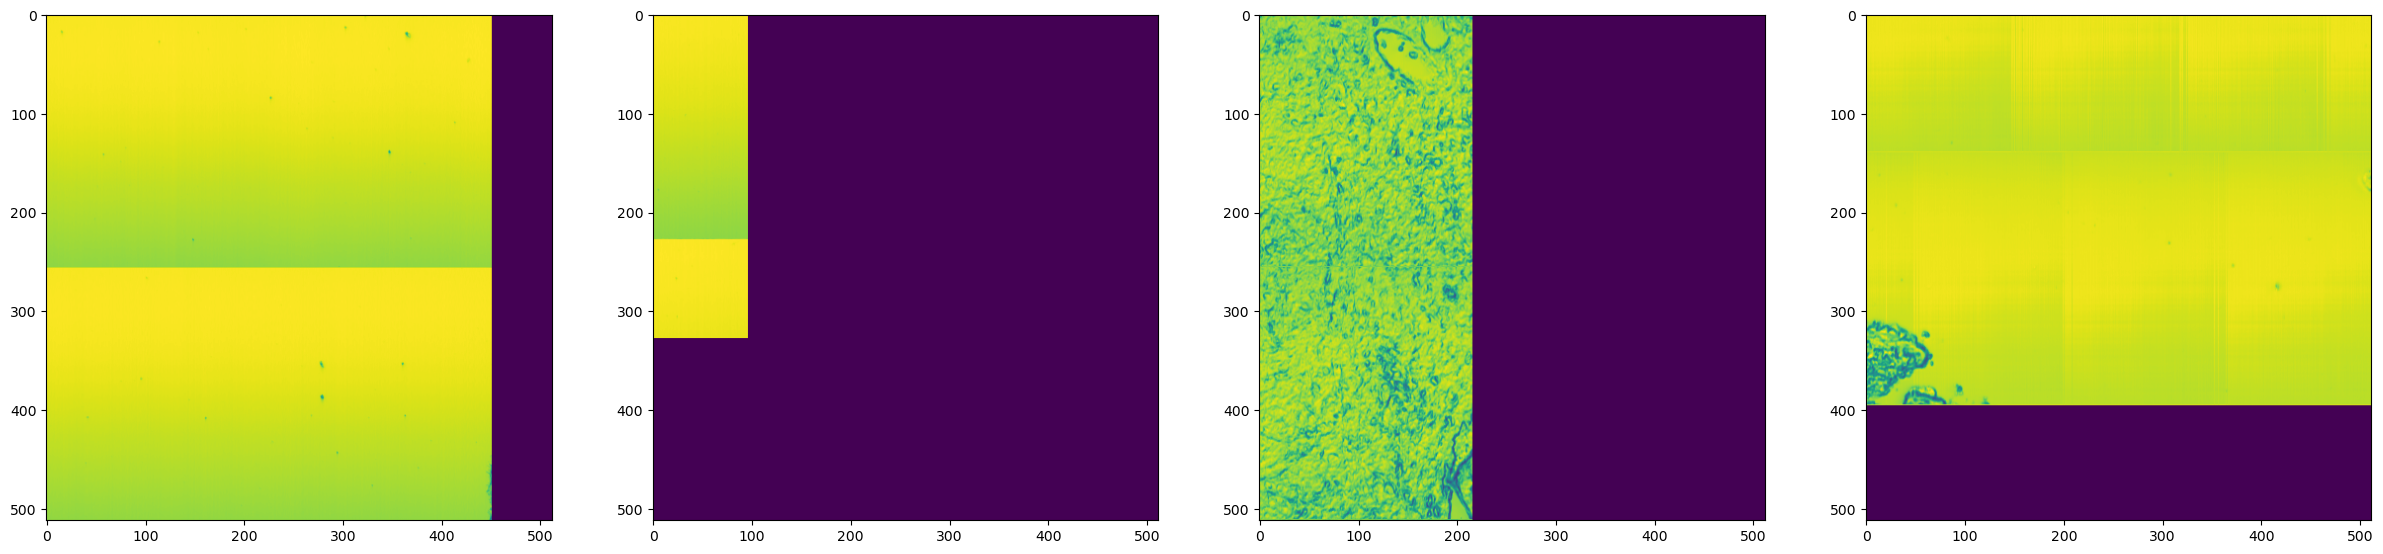

In [51]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
for i, proto in enumerate(interesting_prototypes[:4]):
    axes[i].imshow(proto[:, :, 21])
plt.show()

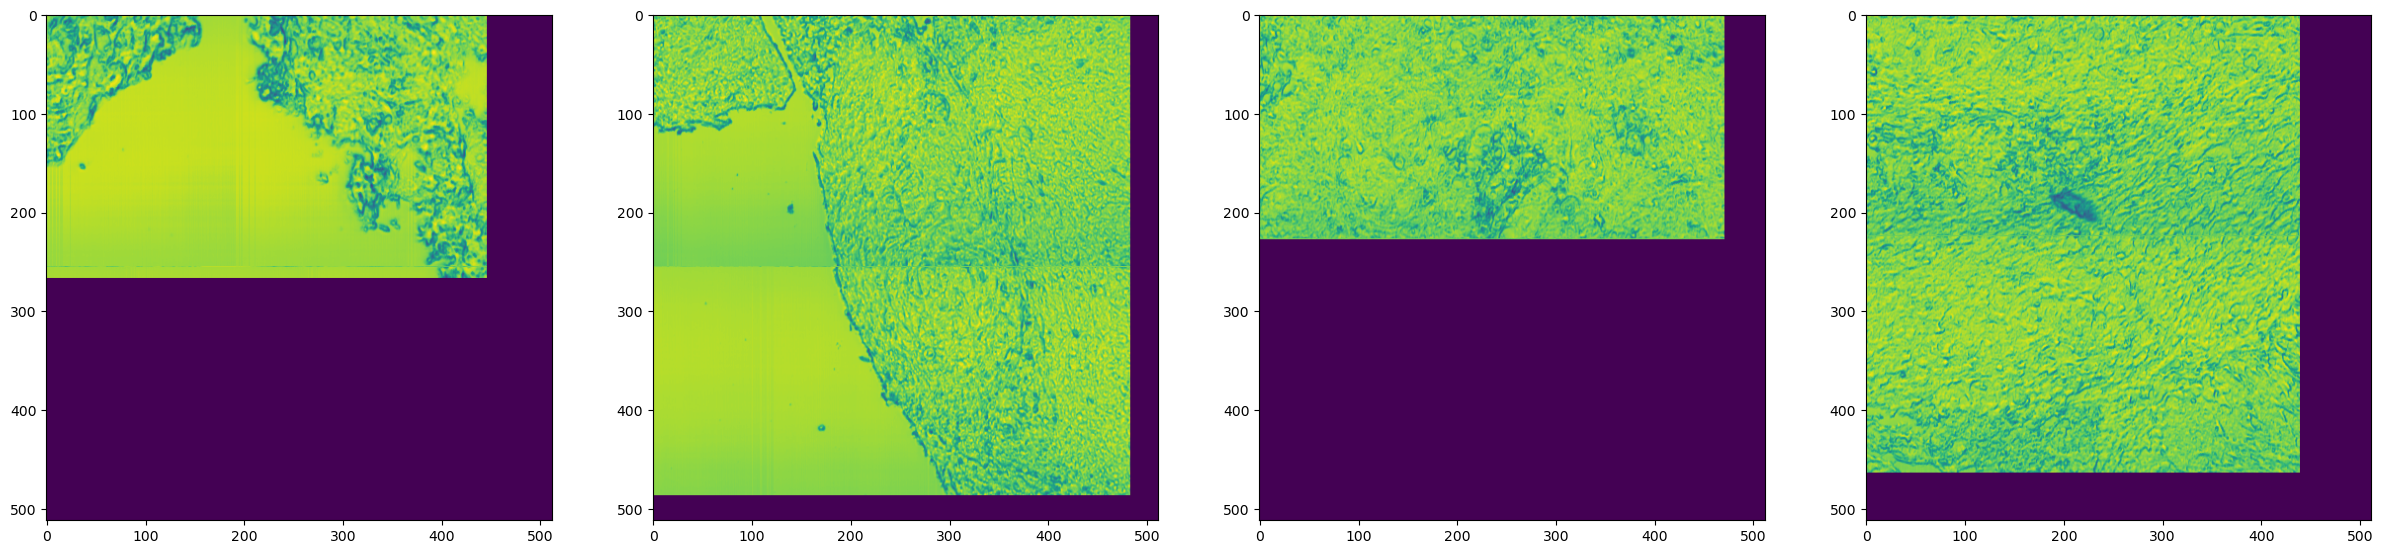

In [52]:
# plot side by side
fig, axes = plt.subplots(1, 4, figsize=(30, 20))
for i, proto in enumerate(interesting_prototypes[4:]):
    axes[i].imshow(proto[:, :, 21])
plt.show()

In [53]:
@dataclass
class BoundingBox:
    index: int
    bounds: list[int]

In [54]:
bounding_box_data = []
with open(os.path.join(PROTOTYPE_PATH, "prototype_bounds.txt"), 'r') as f:
    for s in f:
        index_match = re.search(r'index=(\d+)', s)
        index = int(index_match.group(1)) if index_match else None

        # Extract bounds
        bounds_match = re.search(r'bounds=\[([^\]]+)\]', s)
        bounds = list(map(int, bounds_match.group(1).split(','))) if bounds_match else None
        bounding_box = BoundingBox(index=index, bounds=bounds)
        bounding_box_data.append(bounding_box)

In [55]:
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [56]:
def patchify(big_img, conf):
    # h, w, c = big_img.shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    tmp_img = big_img.unfold(0, ph, sh).unfold(1, pw, sw)  # N1, N2, C, H, W
    tmp_img = tmp_img.reshape(
        tmp_img.shape[0] * tmp_img.shape[1], tmp_img.shape[2], ph, pw
    )
    return tmp_img

In [57]:
def expected_patchify_shape(big_img_shape, conf):
    h, w, c = big_img_shape
    ph, pw = conf['training']['patch_size']
    sh, sw = conf['training']['stride']
    # Calculate the number of patches along the height (N1)
    # N1 = floor((H - ph) / sh) + 1
    n1 = math.floor((h - ph) / sh) + 1
    # Calculate the number of patches along the width (N2)
    # N2 = floor((W - pw) / sw) + 1
    n2 = math.floor((w - pw) / sw) + 1
    # The final shape after reshape is (N1 * N2, C, ph, pw)
    num_patches = n1 * n2
    return (num_patches, c, ph, pw)

In [58]:
train_ids = conf['data']['train_ids']

In [59]:
def load_filtered_patches_raman(raman_id, conf):
    patient_id = raman_id.split('_')[0]
    raman_ref = np.load(f"/home/ct678/code/charm_data/{patient_id}/{raman_id}_SRS_corrected.npy", mmap_mode='r')
    patched_raman = patchify(torch.from_numpy(raman_ref), conf)
    # filter out background patches
    all_zero = torch.all(patched_raman == 0, dim=(1, 2, 3))
    ids_to_include = torch.where(~all_zero)[0]
    patched_raman = patched_raman[ids_to_include]
    return patched_raman, ids_to_include

In [60]:
def locate_sample_and_index(train_ids, bounding_box_index):
    current_index_start = 0
    for train_id in tqdm(train_ids):
        patched_raman, ids_to_include = load_filtered_patches_raman(train_id, conf)
        next_index_start = current_index_start + patched_raman.shape[0]
        if current_index_start <= bounding_box_index < next_index_start:
            located_sample = train_id
            index_within_sample = bounding_box_index - current_index_start
            return located_sample, index_within_sample, ids_to_include
        current_index_start = next_index_start
    raise ValueError(f"Bounding box index {bounding_box_index} not found in train IDs.")

In [61]:
def get_hne_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    hne_located = np.load(os.path.join(f"{HNE_PATH}", f"{located_sample}_align_hne.npy"), mmap_mode='r')
    hne_downsized = cv2.resize(hne_located, (hne_located.shape[1] // 2, hne_located.shape[0] // 2), interpolation=cv2.INTER_LINEAR)
    patched_hne = patchify(torch.from_numpy(hne_downsized), conf)
    patched_hne = patched_hne[ids_to_include]

    selected_patch = patched_hne[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

In [62]:
def get_mask_bound(located_sample, index_within_sample, ids_to_include, bounding_box_bounds):
    mask_path = np.load(os.path.join(f"{MASK_PATH}", f"{located_sample}.npy"), mmap_mode='r')
    mask_downsized = cv2.resize(mask_path, (mask_path.shape[1] // 2, mask_path.shape[0] // 2), interpolation=cv2.INTER_NEAREST)
    mask_downsized = np.expand_dims(mask_downsized, axis=-1)  # Add channel dimension
    patched_mask = patchify(torch.from_numpy(mask_downsized), conf)
    patched_mask = patched_mask[ids_to_include]

    selected_patch = patched_mask[index_within_sample]
    selected_bound = selected_patch[:, bounding_box_bounds[0]:bounding_box_bounds[1], bounding_box_bounds[2]:bounding_box_bounds[3]]
    return selected_bound.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

In [63]:
bounding_boxes_to_check = [bounding_box_data[i] for i in interesting_prototypes_i]
len(bounding_boxes_to_check)

8

# Mask Analysis

In [37]:
def class_presence(prototype_bounding_box):
    # class ratios out of a maximum 15 classes
    class_ratios = []
    for bounding_box in prototype_bounding_box:
        located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box.index)
        mask_bound = get_mask_bound(located_sample, index_within_sample, ids_to_include, bounding_box.bounds)
        classes = np.unique(mask_bound, return_counts=True)
        class_counts = dict(zip(classes[0], classes[1]))
        # default to 0 for classes not present
        class_ratio = {i: class_counts.get(i, 0) / mask_bound.size for i in range(15)}
        class_ratios.append(class_ratio)
    return class_ratios

In [38]:
class_ratios = class_presence(bounding_boxes_to_check[:2])
len(class_ratios)

 16%|█▌        | 3/19 [00:23<02:05,  7.85s/it]


2

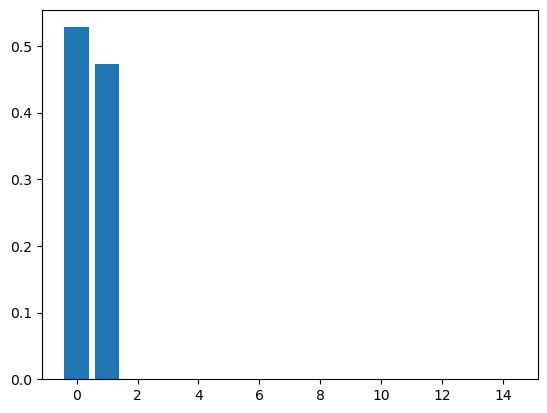

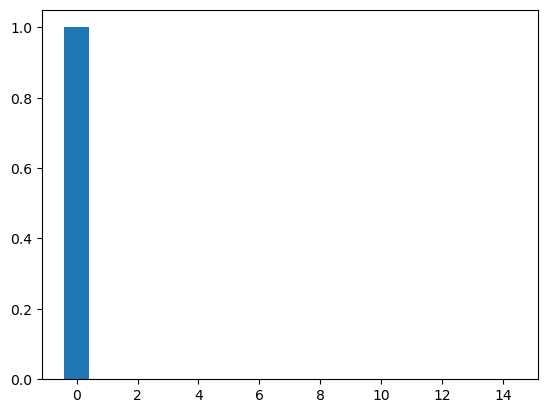

In [40]:
for ratios in class_ratios:
    vals = list(ratios.values())
    plt.bar(range(len(vals)), vals)
    plt.show()

 32%|███▏      | 6/19 [00:39<01:26,  6.65s/it]


(array([0], dtype=uint8), array([230912]))


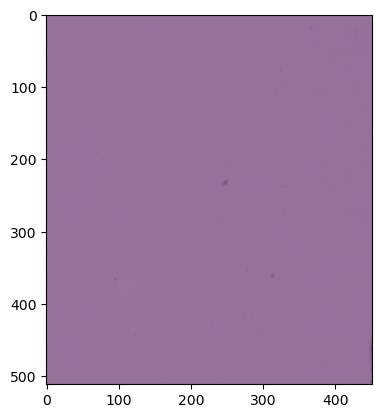

 21%|██        | 4/19 [00:29<01:50,  7.34s/it]


(array([0], dtype=uint8), array([31488]))


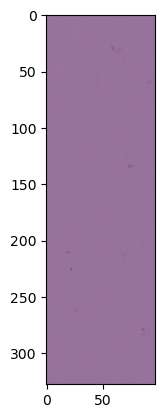

 42%|████▏     | 8/19 [00:52<01:11,  6.53s/it]


(array([ 0,  1, 10, 13], dtype=uint8), array([79820, 28895,  1453,   424]))


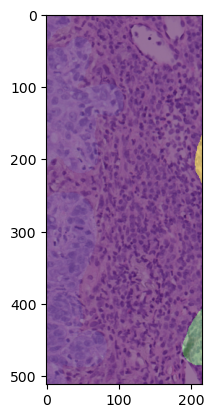

 37%|███▋      | 7/19 [00:42<01:12,  6.02s/it]


(array([0], dtype=uint8), array([202752]))


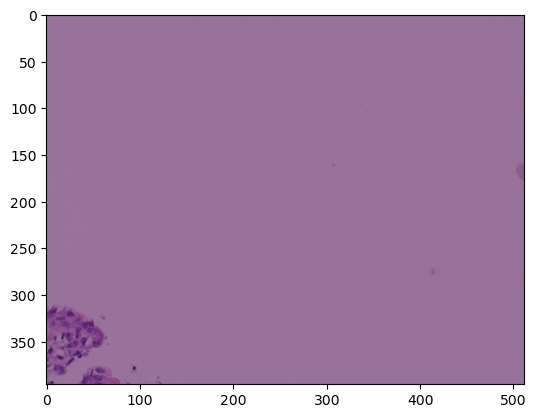

 37%|███▋      | 7/19 [00:42<01:12,  6.06s/it]


(array([0, 1], dtype=uint8), array([89500, 29582]))


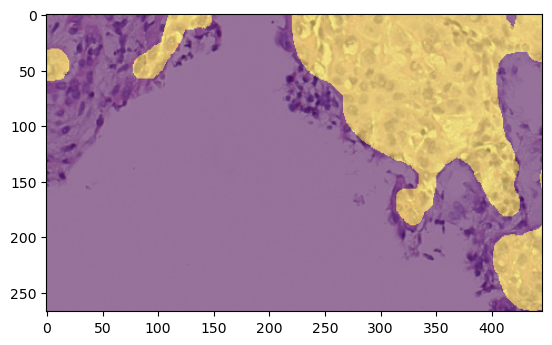

  0%|          | 0/19 [00:05<?, ?it/s]


(array([0, 1], dtype=uint8), array([113489, 121732]))


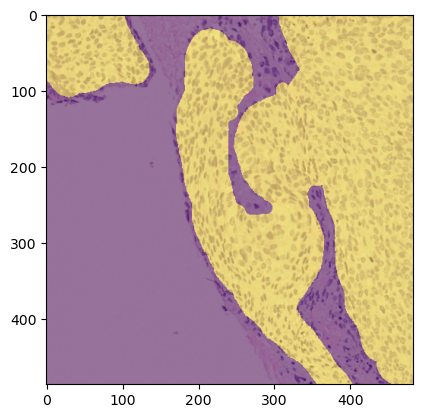

 16%|█▌        | 3/19 [00:21<01:53,  7.11s/it]


(array([0, 1], dtype=uint8), array([15614, 91774]))


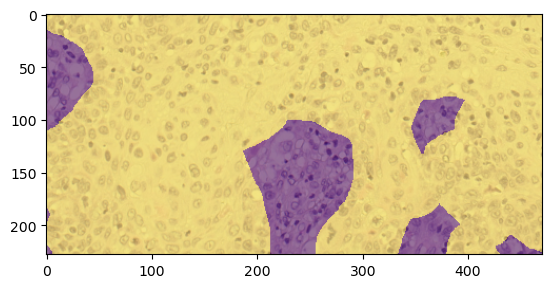

  5%|▌         | 1/19 [00:11<03:19, 11.07s/it]


(array([0, 1], dtype=uint8), array([ 39947, 163749]))


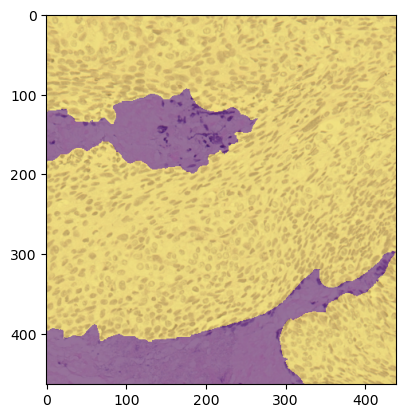

In [64]:
for bounding_box in bounding_boxes_to_check:
    bounding_box_index = bounding_box.index
    bounds = bounding_box.bounds
    located_sample, index_within_sample, ids_to_include = locate_sample_and_index(train_ids, bounding_box_index)
    mask_bound = get_mask_bound(located_sample, index_within_sample, ids_to_include, bounds)
    print(np.unique(mask_bound, return_counts=True))
    hne_bound = get_hne_bound(located_sample, index_within_sample, ids_to_include, bounds)
    plt.imshow(hne_bound)
    plt.imshow(mask_bound, alpha=0.5)
    plt.show()

# Spectral Differences

In [26]:
def channel_stats(patch):
    mean = np.mean(patch, axis=(0, 1))
    std = np.std(patch, axis=(0, 1))
    return mean, std

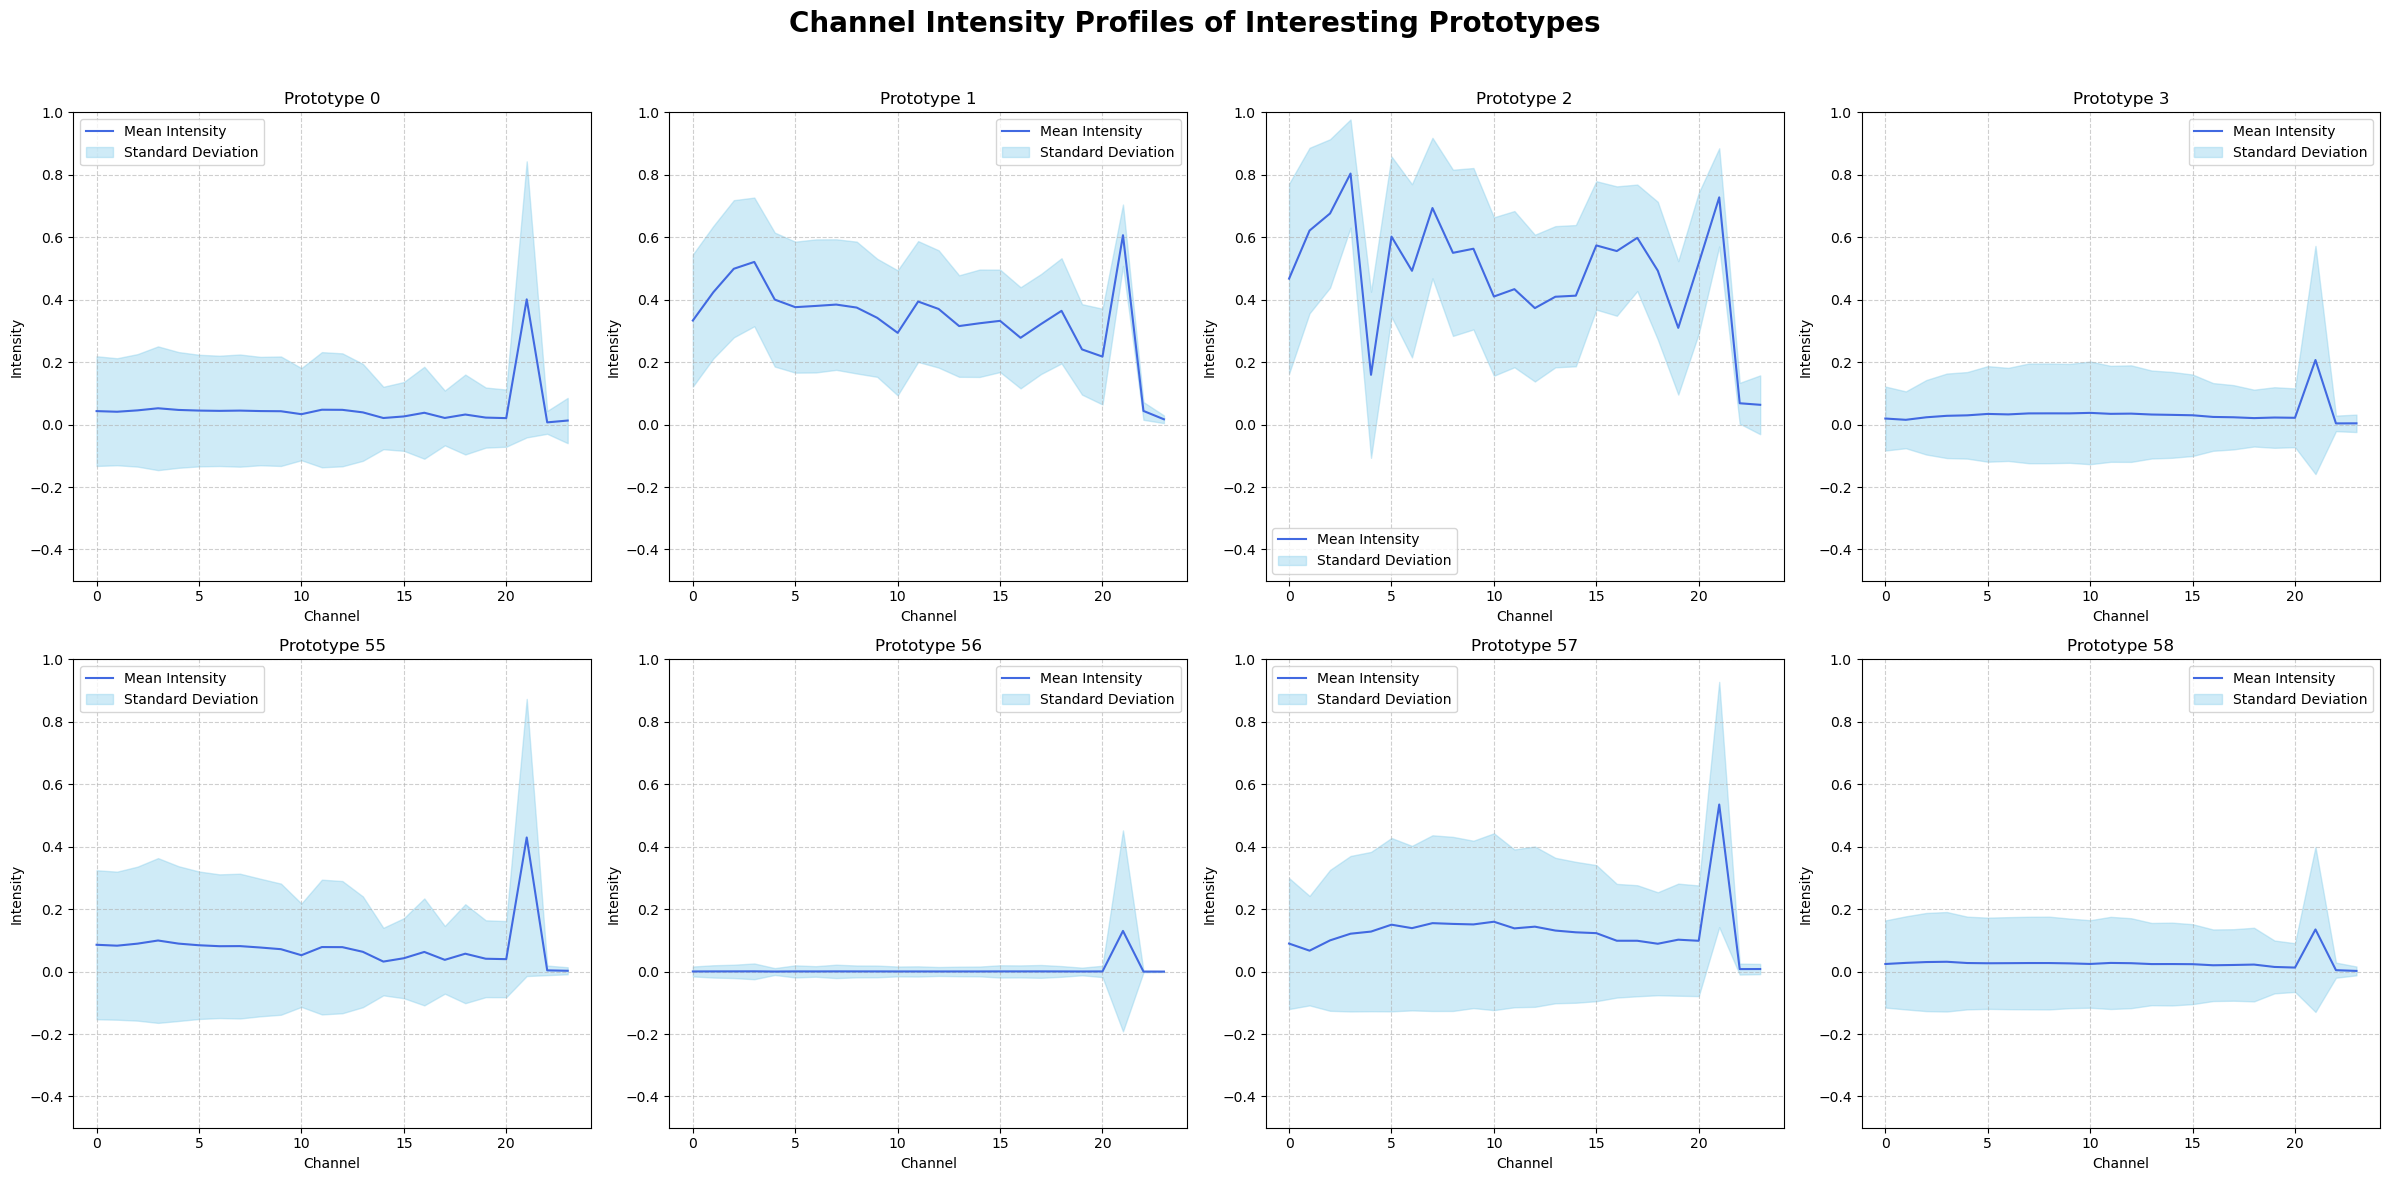

In [28]:
# Create subplots to visualize the channel stats for each interesting prototype
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each interesting prototype and its original index
for i, (proto_idx, prototype) in enumerate(zip(interesting_prototypes_i, interesting_prototypes)):
    # Calculate the mean and standard deviation for the channels
    mean, std = channel_stats(prototype)
    
    # Create an array representing the channel numbers for the x-axis
    channels = np.arange(len(mean))
    
    # Plot the mean intensity
    axes[i].plot(channels, mean, label='Mean Intensity', color='royalblue')
    
    # Create a shaded region for the standard deviation
    axes[i].fill_between(channels, mean - std, mean + std, color='skyblue', alpha=0.4, label='Standard Deviation')
    
    # Set the title and labels for the subplot
    axes[i].set_title(f'Prototype {proto_idx}')
    axes[i].set_xlabel('Channel')
    axes[i].set_ylabel('Intensity')
    axes[i].set_ylim(-0.5, 1.0)
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Add a main title to the figure
plt.suptitle('Channel Intensity Profiles of Interesting Prototypes', fontsize=20, weight='bold')

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()